In [6]:
import numpy as np
import sys
import re
import os
import pandas as pd
import warnings
from pathlib import Path
from typing import List, Dict, Tuple, Any, Union, Callable
from tqdm import tqdm
import csv
import json
from dataclasses import dataclass
from datetime import datetime
from configobj import ConfigObj, Section
import shutil
from tempfile import NamedTemporaryFile
import arviz as az
import ultranest

# Autoreload extension
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
WDIR = Path().cwd().parent

PLANET_DB_PATH = str(WDIR / "data/planet_database_composite.csv")
OPACITY_PATH = str(WDIR / "data/Input/xsec/xsec_sampled_R15000_0.3-15")
CIA_PATH = str(WDIR / "data/Input/cia/hitran")
KTABLE_PATH = str(WDIR / "data/Input/ktables/R100")
MOLECULE_PATH = str(WDIR / "data/molecule_db.json")

SPECTRA_BE_PATH = str(WDIR / "data/SpectraBE")
SPECTRA_LW_PATH = str(WDIR / "data/taurex_lightcurves_LW")

outfile = str(WDIR / "data/retrievals/SYNTHETIC/default_out.hdf5")
outfile_ultranest_points = str(WDIR / "data/retrievals/SYNTHETIC/ultranest_single_dir/run1/results/points.hdf5")
outfile_ultranest = str(WDIR / "data/retrievals/SYNTHETIC/ultranest_single_dir/run1/info/results.json")
log_dir_ultranest = str(WDIR / "data/retrievals/SYNTHETIC/ultranest_single_dir/run1")

In [27]:
with open(outfile_ultranest) as f:
    result = json.load(f)

    print(result)

{'niter': 8827, 'logz': 3667.9202255210453, 'logzerr': 0.18628826382732663, 'logz_bs': 3667.9172800981924, 'logz_single': 3667.9202255210453, 'logzerr_tail': 0.009931454463185219, 'logzerr_bs': 0.18602334114848418, 'ess': 2371.6910903834923, 'H': 10.55917149896959, 'Herr': 0.11194150465307975, 'posterior': {'mean': [1.4997912558639575, 1496.7227329691123, -2.9766946658601374, -7.025596097460647, -6.97928462091255], 'stdev': [0.0024428657464611704, 26.092226768372193, 0.1526405067863547, 0.5715680590688242, 0.5698210441249035], 'median': [1.4999261413007516, 1496.6469864868789, -2.984762061860617, -7.02983831902444, -6.953811582584757], 'errlo': [1.4973435298156583, 1470.3047821025257, -3.128701791004002, -7.687764280839154, -7.66579845512485], 'errup': [1.5022495668584863, 1523.2210558668269, -2.8265809378641586, -6.3603886147521305, -6.318641754535299], 'information_gain_bits': [4.131325314714536, 2.346642258482829, 0.7302743982796125, -5.180373863852206, -5.175657743078926]}, 'maximu

dict_keys(['logz', 'logzerr', 'logvol', 'samples_n', 'nlive', 'insert_order', 'logwt', 'niter', 'logl', 'weights', 'samples'])
dict_keys(['niter', 'logz', 'logzerr', 'logz_bs', 'logz_single', 'logzerr_tail', 'logzerr_bs', 'ess', 'H', 'Herr', 'posterior', 'weighted_samples', 'samples', 'maximum_likelihood', 'insertion_order_MWW_test'])


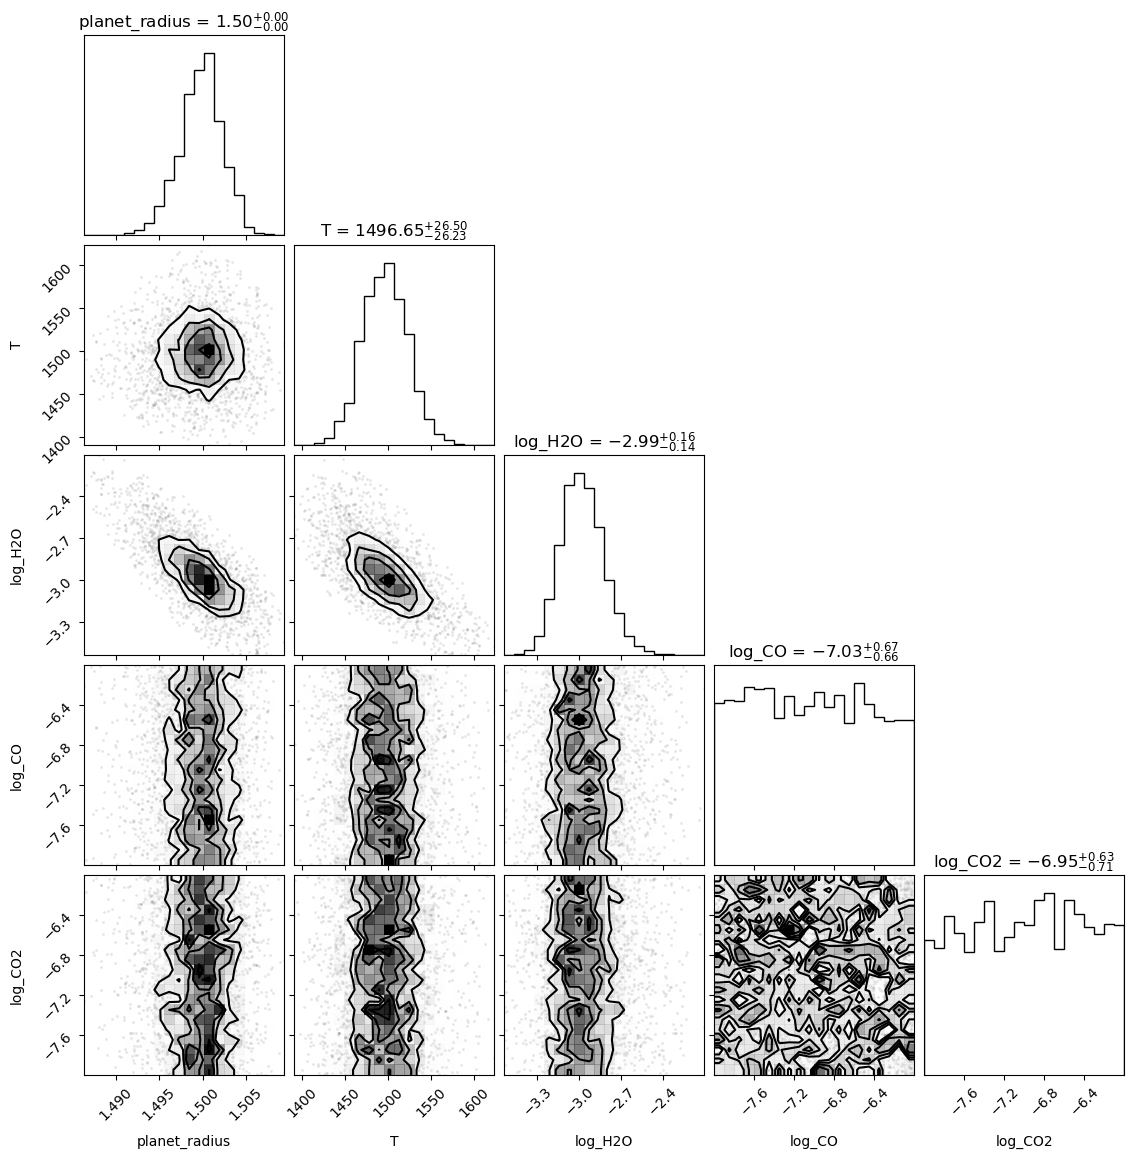

In [28]:
from ultranest.integrator import warmstart_from_similar_file, read_file
from ultranest.plot import cornerplot

pars = ["planet_radius", "T_irr", "log_kappa_irr", "log_kappa_v1", "log_kappa_v2", "log_alpha",
                       "log_H2O", "log_CH4", "log_NH3", "log_CO", "log_CO2", "log_HCN", "log_Na", "log_K", "log_TiO", "log_VO", "log_FeH", "log_e-", "Offset_2", "Slope_2"]

pars = ["planet_radius", "T",
                       "log_H2O", "log_CO", "log_CO2"]

sequence, final = read_file(log_dir_ultranest, x_dim=len(pars),  random=True, verbose=False, check_insertion_order=True)

print(sequence.keys())
print(final.keys())

final['paramnames'] = pars

import logging
logger = logging.getLogger()

cornerplot(final)




In [29]:
print(final['weighted_samples'].keys())
print(final['samples'].shape)

dict_keys(['upoints', 'points', 'weights', 'logw', 'bootstrapped_weights', 'logl'])
(8856, 5)


In [30]:
data_dict = {k: v for k, v in zip(pars, final['samples'].T)}

dataset = az.convert_to_inference_data(data_dict)

array([[<Axes: title={'center': 'planet_radius'}>,
        <Axes: title={'center': 'planet_radius'}>],
       [<Axes: title={'center': 'T'}>, <Axes: title={'center': 'T'}>],
       [<Axes: title={'center': 'log_H2O'}>,
        <Axes: title={'center': 'log_H2O'}>],
       [<Axes: title={'center': 'log_CO'}>,
        <Axes: title={'center': 'log_CO'}>],
       [<Axes: title={'center': 'log_CO2'}>,
        <Axes: title={'center': 'log_CO2'}>]], dtype=object)

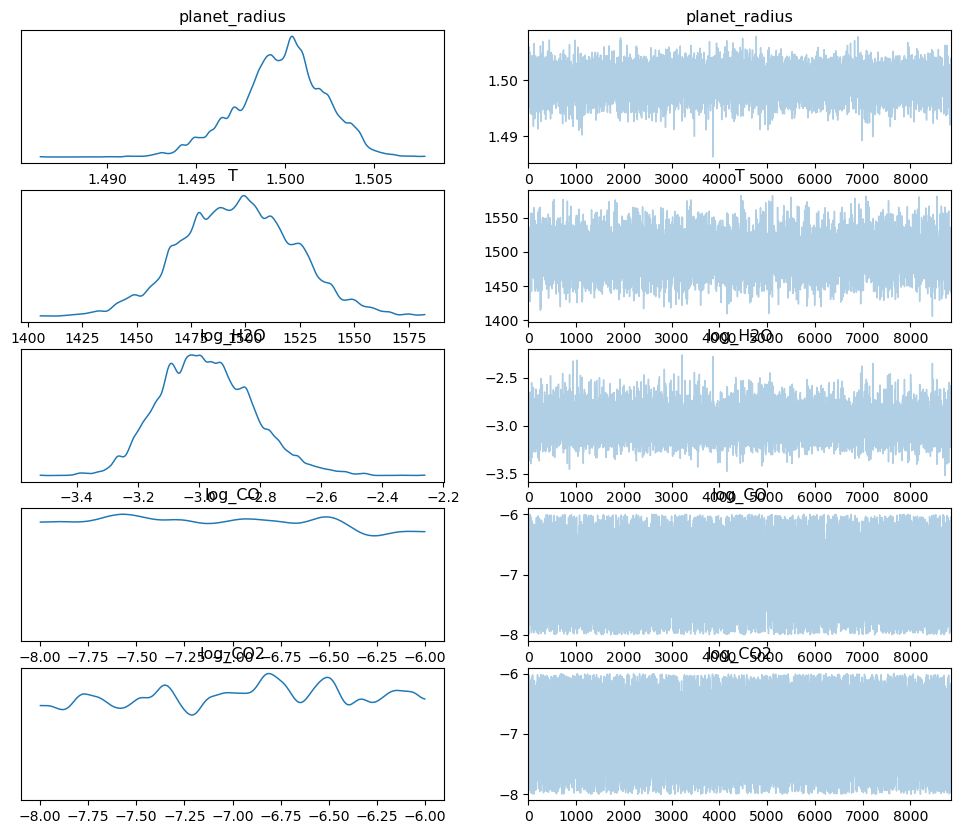

In [31]:
az.plot_trace(dataset, var_names=pars)

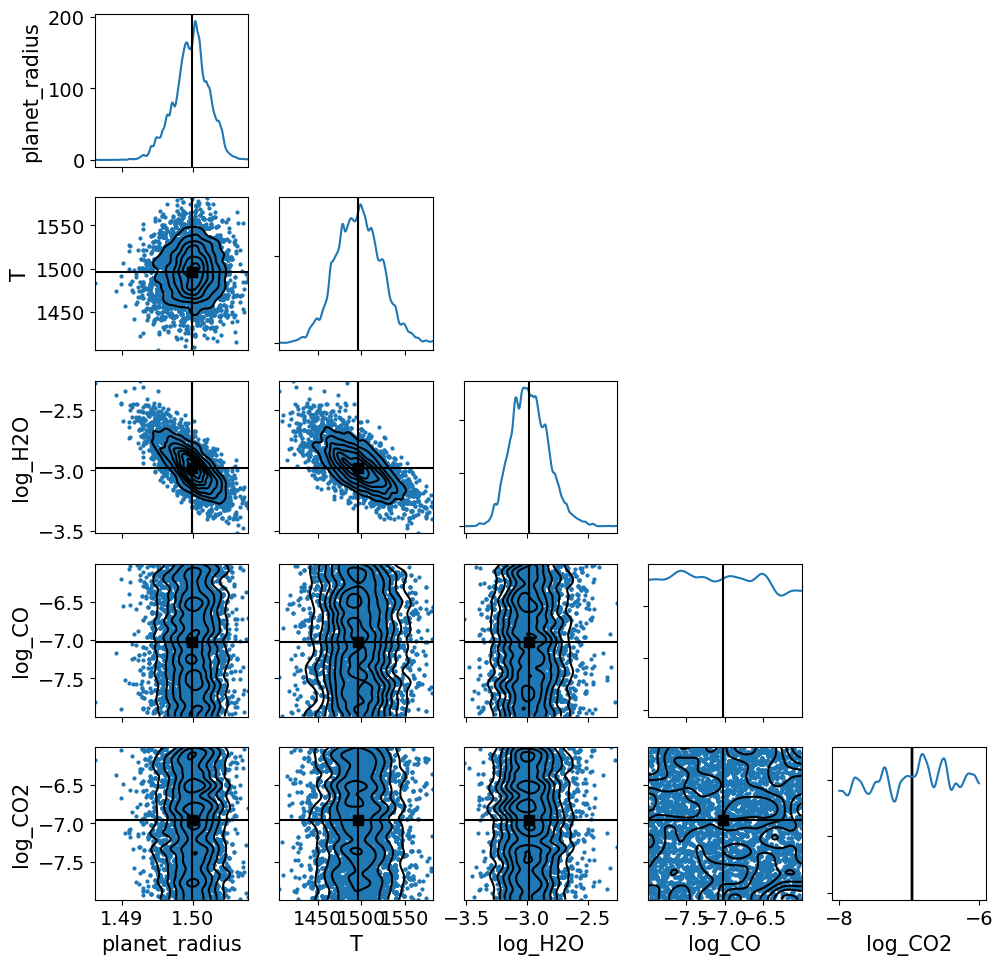

In [32]:
ax = az.plot_pair(
    dataset,
    var_names=pars,
    kind=["scatter", "kde"],
    kde_kwargs={"fill_last": False},
    marginals=True,
    point_estimate="median",
    figsize=(11.5, 11.5),
)